# Pipeline Suitability Analysis

This notebook demonstrates the workflow for finding optimal pipeline paths using geospatial suitability analysis. The analysis consists of:

1. Loading raster factors and reference paths
2. Creating cost maps with weighted factors
3. Finding least cost paths between points
4. Comparing predicted paths with reference paths
5. Optimizing weights to improve path prediction

## Setup and Import Libraries

In [2]:
# Import required libraries
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import time
import warnings
warnings.filterwarnings('ignore')

# Import our custom pipeline analysis modules
from pipefit.data_loader import DataLoader, load_reference_path
from pipefit.cost_map import CostMapGenerator
from pipefit.path_finder import LeastCostPathFinder
from pipefit.path_evaluator import PathEvaluator

## 1. Load Dataset

First, we'll load a dataset containing raster factors and reference path.

In [4]:
# Set the path to your dataset folder
dataset_path = "datasets/test_dataset"

# Define a factor mapping (optional)
factor_mapping = {
    # Map filename to standardized name      
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands'
}

# Create a data loader and load the data
data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)

# Load reference path separately
reference_path_dir = os.path.join(dataset_path, 'reference')
reference_path = load_reference_path(reference_path_dir)

Loaded 9 raster factors: ['wetlands', 'protected_areas', 'slope', 'proximity_to_cities', 'highwayMask', 'wetland2Mask', 'railways', 'rivers', 'wetland1Mask']
Loaded reference path from datasets/test_dataset/reference/test_reference_pipeline.geojson


## 2. Visualize Input Factors

Let's examine the normalized raster factors that we'll use to create the cost map.

In [5]:
# Create a cost map generator
cost_generator = CostMapGenerator(data_loader.factors)

# Visualize all input factors
# cost_generator.visualize_factors(figsize=(15, 10))

## 3. Generate Cost Map

Now we'll create a cost map by combining factors with weights. The weights reflect the relative importance of each factor in determining pipeline suitability.

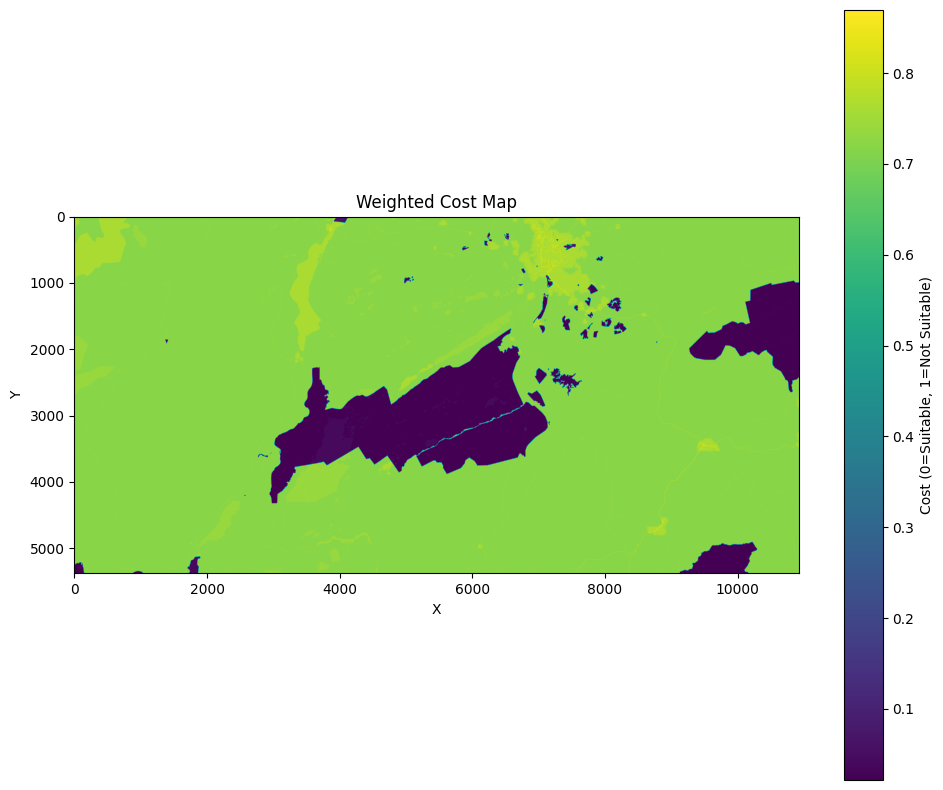

Saved raster to datasets/test_dataset/results/cost_map.tif


In [8]:
# Define weights for each factor
# These can be different from the factor names in the data files
weights = {
    'protected_areas': 0.8,   
    'proximity_to_cities': 0.05, 
    'slope': 0.05, 
    'railways': 0.05,          
    'rivers': 0.025,        
    'wetlands': 0.025        
}

# # Optional: Define a weight-to-factor mapping if your weight keys don't match factor names
weight_mapping = None  # We're using standardized names, so no mapping needed

# Generate cost map with default weight for any missing factors
cost_map = cost_generator.generate_cost_map(
    weights=weights,
    default_weight=0.05,  # Any factors without explicit weights get this value
    weight_mapping=weight_mapping
)

# Visualize cost map
cost_generator.visualize_cost_map(cost_map, title="Weighted Cost Map")

# Save cost map (optional)
cost_map_path = os.path.join(dataset_path, 'results', 'cost_map.tif')
os.makedirs(os.path.dirname(cost_map_path), exist_ok=True)
data_loader.save_raster(cost_map, cost_map_path)

## 4. Find Least Cost Path

Using the cost map, we'll find the least cost path between start and end points.

Start point: None, End point: None
Path found with total cost: 6056.22034562195


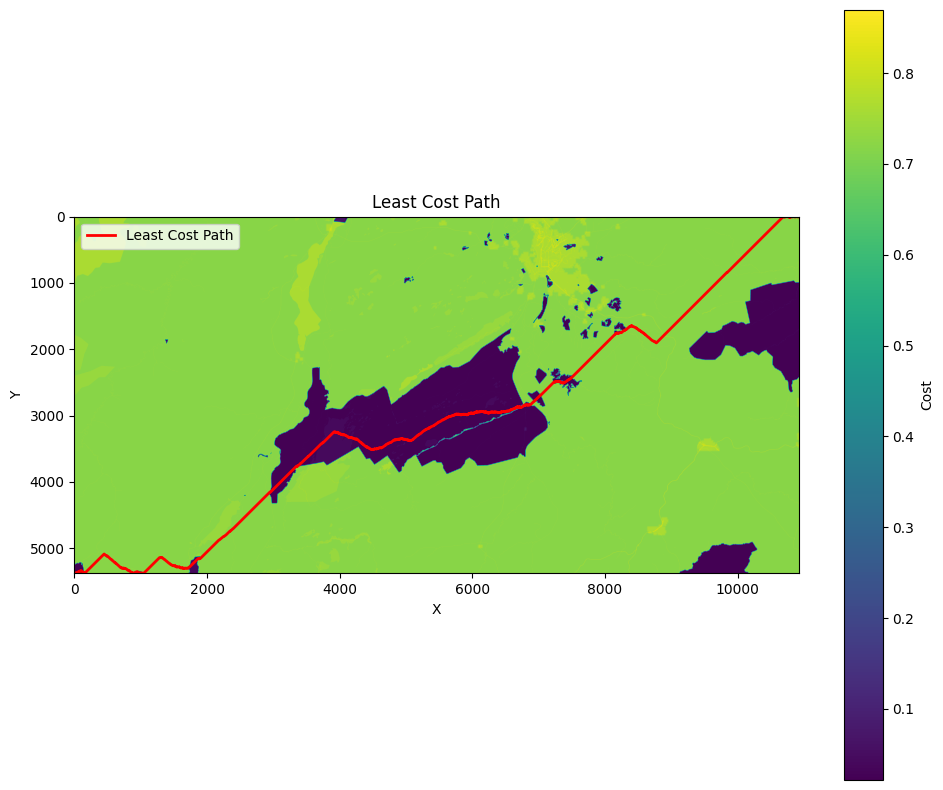

In [9]:
# Define start and end points
# Option 1: Define using geographical coordinates
# start_x, start_y = -120.5, 38.2  # Example coordinates (replace with actual coordinates)
# end_x, end_y = -119.8, 38.7     # Example coordinates (replace with actual coordinates)

# # Convert to raster indices
# start_indices = data_loader.coordinates_to_indices(start_x, start_y)
# end_indices = data_loader.coordinates_to_indices(end_x, end_y)

# Option 2: Define directly as raster indices
# start_indices = (100, 50)   # Example indices (row, col) (replace with actual indices)
# end_indices = (400, 300)    # Example indices (row, col) (replace with actual indices)

# Option 3: Use default start/end points (lower left to upper right)
start_indices = None  # Will use lower left corner
end_indices = None    # Will use upper right corner

print(f"Start point: {start_indices}, End point: {end_indices}")

# Create path finder (no need to pass transform/crs at initialization)
path_finder = LeastCostPathFinder(cost_map)

# Get metadata for later use
metadata = data_loader.get_common_metadata()

# Find least cost path using A* algorithm (default)
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  # 'astar' or 'dijkstra'
    fully_connected=True  # Use 8-connected neighbors
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

## 5. Compare with Reference Path

Now we'll compare our predicted path with the reference (ground truth) path and calculate similarity metrics.

Path Comparison Metrics:
hausdorff_distance: 16593.2547
average_min_distance: 4609.8104
buffer_overlap: 0.2343
path_length_ratio: 1.0014
combined_score: 0.6829


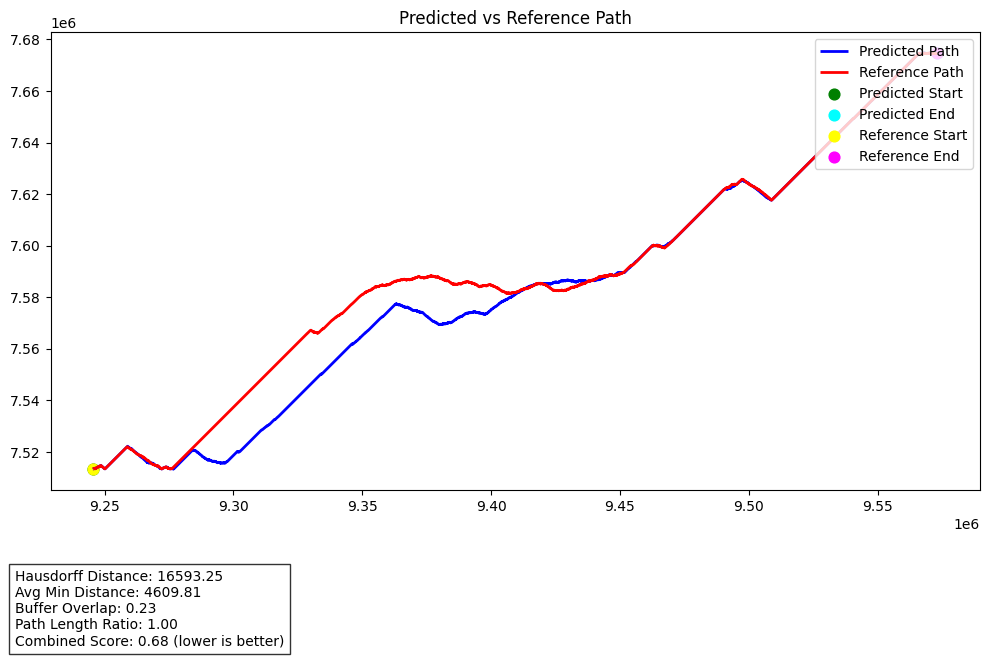

In [10]:
# Create path evaluator with reference path passed explicitly
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=reference_path,  # Pass the reference path directly
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=100)  # Adjust buffer distance as needed

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

## 6. Experiment with Different Weights

Let's experiment with different weight combinations to see which produces paths that better match the reference path.


Trying weight combination 1:
{'protected_areas': 0.8, 'proximity_to_cities': 0.05, 'slope': 0.05, 'railways': 0.05, 'rivers': 0.025, 'wetlands': 0.025}
hausdorff_distance: 16593.2547
average_min_distance: 4609.8104
buffer_overlap: 0.2343
path_length_ratio: 1.0014
combined_score: 0.6829


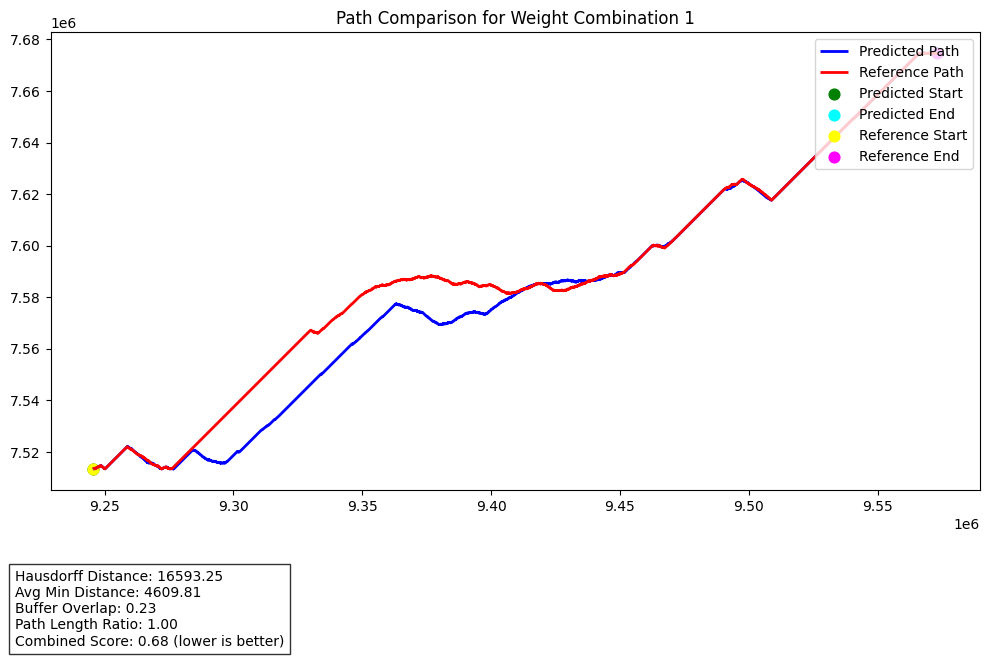


Trying weight combination 2:
{'protected_areas': 0.1, 'proximity_to_cities': 0.05, 'slope': 0.5, 'railways': 0.5, 'rivers': 0.25, 'wetlands': 0.5}
hausdorff_distance: 9890.5409
average_min_distance: 1089.2147
buffer_overlap: 0.3441
path_length_ratio: 1.0013
combined_score: 0.5603


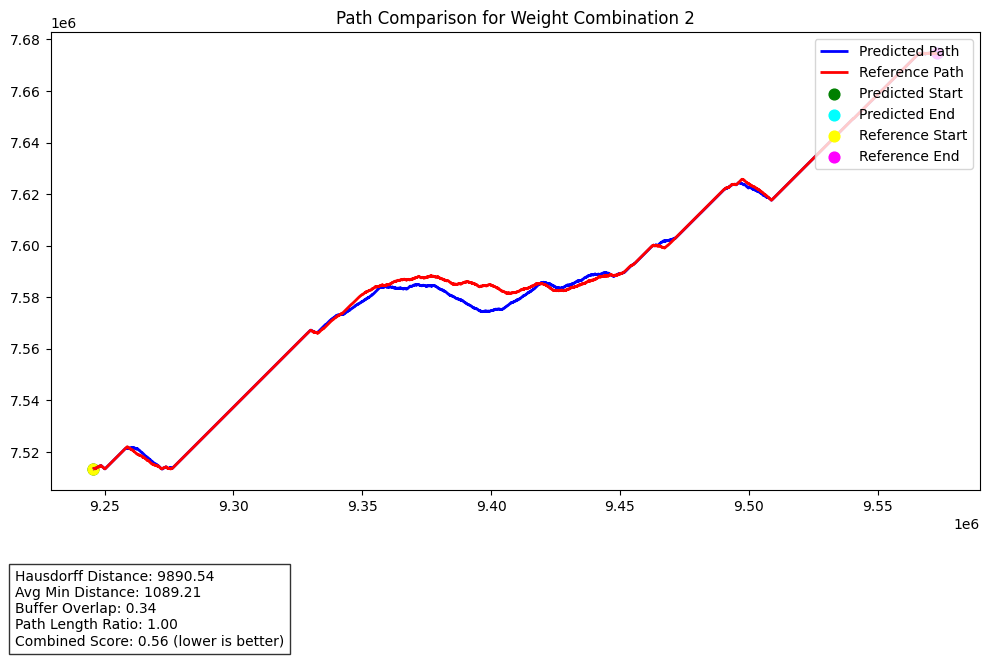


Trying weight combination 3:
{'protected_areas': 0.1, 'proximity_to_cities': 0.1, 'slope': 0.1, 'railways': 0.1, 'rivers': 0.1, 'wetlands': 0.1}
hausdorff_distance: 11315.8871
average_min_distance: 1434.0643
buffer_overlap: 0.3876
path_length_ratio: 1.0022
combined_score: 0.5753


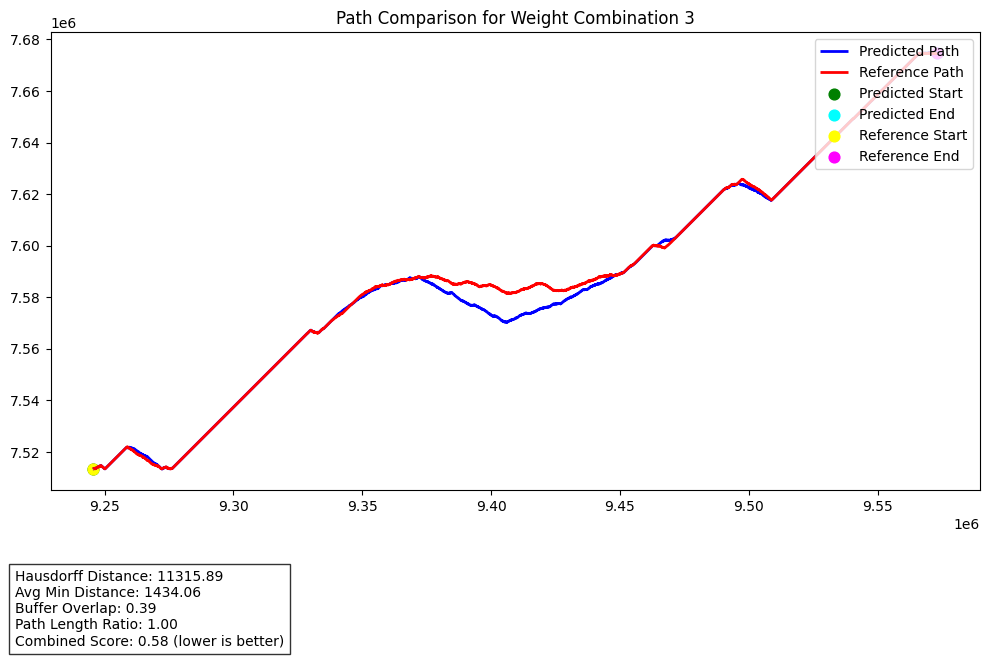

In [13]:
# Define several weight combinations to try
weight_combinations = [
    {
        'protected_areas': 0.8,   
        'proximity_to_cities': 0.05, 
        'slope': 0.05, 
        'railways': 0.05,          
        'rivers': 0.025,        
        'wetlands': 0.025        
    },
    {
        'protected_areas': 0.1,   
        'proximity_to_cities': 0.05, 
        'slope': 0.5, 
        'railways': 0.5,          
        'rivers': 0.25,        
        'wetlands': 0.5        
    },
    {
        'protected_areas': 0.1,   
        'proximity_to_cities': 0.1, 
        'slope': 0.1, 
        'railways': 0.1,          
        'rivers': 0.1,        
        'wetlands': 0.1        
    },
]

# Store results
results = []

# Try each weight combination
for i, weights in enumerate(weight_combinations):
    print(f"\nTrying weight combination {i+1}:")
    print(weights)
    
    # Generate cost map
    cost_map = cost_generator.generate_cost_map(
        weights=weights,
        default_weight=0.05  # Use a default weight for any missing factors
    )
    
    # Create path finder
    path_finder = LeastCostPathFinder(cost_map)
    
    # Find least cost path using A* algorithm
    path_indices, path_cost = path_finder.find_path(
        start_indices, 
        end_indices, 
        method='astar'
    )
    
    # Evaluate path
    evaluator = PathEvaluator(
        predicted_path=path_indices,
        reference_path=reference_path,  # Pass reference path directly
        transform=metadata['transform'],
        crs=metadata['crs']
    )
    
    metrics = evaluator.evaluate_all_metrics(buffer_distance=100)
    
    # Store results
    results.append({
        'weights': weights,
        'path_cost': path_cost,
        'metrics': metrics
    })
    
    # Display metrics
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Visualize comparison
    evaluator.visualize_paths(title=f"Path Comparison for Weight Combination {i+1}", 
                             buffer_distance=100)

## 7. Identify Best Weight Combination

Now we'll identify which weight combination produced the best match to the reference path.

In [14]:
# Find the best combination based on the combined score
combined_scores = [result['metrics']['combined_score'] for result in results]
best_index = combined_scores.index(min(combined_scores))
best_weights = results[best_index]['weights']

print("\nBest weight combination:")
for factor, weight in best_weights.items():
    print(f"{factor}: {weight:.2f}")

print("\nMetrics for best combination:")
for metric_name, value in results[best_index]['metrics'].items():
    print(f"{metric_name}: {value:.4f}")


Best weight combination:
protected_areas: 0.10
proximity_to_cities: 0.05
slope: 0.50
railways: 0.50
rivers: 0.25
wetlands: 0.50
wetland1Mask: 0.05
highwayMask: 0.05
wetland2Mask: 0.05

Metrics for best combination:
hausdorff_distance: 9890.5409
average_min_distance: 1089.2147
buffer_overlap: 0.3441
path_length_ratio: 1.0013
combined_score: 0.5603


## 8. Save Final Results

Finally, let's save the best cost map and path.

In [12]:
# Generate final cost map with best weights
final_cost_map = cost_generator.generate_cost_map(
    weights=weights,
    default_weight=0.05
)

# Find final path using A* algorithm
path_finder = LeastCostPathFinder(final_cost_map)
final_path_indices, final_path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar'
)

# Convert to GeoDataFrame
final_path_gdf = path_finder.path_to_geodataframe(
    final_path_indices, 
    final_path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save results
results_dir = os.path.join(dataset_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Save cost map
final_cost_map_path = os.path.join(results_dir, 'final_cost_map.tif')
data_loader.save_raster(final_cost_map, final_cost_map_path)

# Save path
final_path_output = os.path.join(results_dir, 'final_least_cost_path.shp')
final_path_gdf.to_file(final_path_output)

print(f"Saved final cost map to: {final_cost_map_path}")
print(f"Saved final path to: {final_path_output}")

# Final visualization
evaluator = PathEvaluator(
    predicted_path=final_path_indices,
    reference_path=reference_path,  # Pass reference path directly
    transform=metadata['transform'],
    crs=metadata['crs']
)
evaluator.visualize_paths(title="Final Optimized Path vs Reference Path", buffer_distance=100)

KeyboardInterrupt: 

## 9. Automated Weight Optimization

Let's use our optimization tools to automatically find the best weights for the factors.

### 9.1 Simple Gradient Optimization

## 9.2 Comparing Different Path-Finding Algorithms

Let's compare the A* algorithm with Dijkstra's algorithm using our optimized weights.


Comparing path-finding algorithms with optimized weights...


NameError: name 'best_weights' is not defined

## 11. Process Multiple Datasets

Let's use the enhanced `process_dataset` function to handle multiple datasets:

In [ ]:
def process_dataset(dataset_path, weights, start_coords=None, end_coords=None, factor_mapping=None):
    """Process a single dataset and return metrics."""
    # Load data
    data_loader = DataLoader(dataset_path)
    data_loader.load_data(factor_mapping=factor_mapping)
    
    # Load reference path
    reference_path_dir = os.path.join(dataset_path, 'reference')
    reference_path = load_reference_path(reference_path_dir)
    
    # Generate cost map
    cost_generator = CostMapGenerator(data_loader.factors)
    cost_map = cost_generator.generate_cost_map(
        weights=weights,
        default_weight=0.05
    )
    
    # Get metadata
    metadata = data_loader.get_common_metadata()
    
    # Determine start and end points
    if start_coords and end_coords:
        start_indices = data_loader.coordinates_to_indices(start_coords[0], start_coords[1])
        end_indices = data_loader.coordinates_to_indices(end_coords[0], end_coords[1])
    else:
        # Use first and last points of reference path as default
        ref_geom = reference_path.geometry.iloc[0]
        start_coords = (ref_geom.coords[0][0], ref_geom.coords[0][1])
        end_coords = (ref_geom.coords[-1][0], ref_geom.coords[-1][1])
        start_indices = data_loader.coordinates_to_indices(start_coords[0], start_coords[1])
        end_indices = data_loader.coordinates_to_indices(end_coords[0], end_coords[1])
    
    # Find path using A* algorithm
    path_finder = LeastCostPathFinder(cost_map)
    path_indices, path_cost = path_finder.find_path(
        start_indices, 
        end_indices, 
        method='astar'
    )
    
    # Evaluate path
    evaluator = PathEvaluator(
        predicted_path=path_indices,
        reference_path=reference_path,  # Pass reference path directly
        transform=metadata['transform'],
        crs=metadata['crs']
    )
    
    metrics = evaluator.evaluate_all_metrics()
    
    # Return results
    return {
        'dataset': os.path.basename(dataset_path),
        'cost_map': cost_map,
        'path_indices': path_indices,
        'path_cost': path_cost,
        'metrics': metrics,
        'data_loader': data_loader,
        'metadata': metadata,
        'reference_path': reference_path
    }

# Define factor and weight mappings (if needed)
factor_mappings = {
    'dataset1': {
        'elev.tif': 'elevation',
        'protected.tif': 'protected_areas',
        'cities.tif': 'proximity_to_cities',
        'slope.tif': 'slope',
        'soil.tif': 'soil_type'
    },
    'dataset2': {
        'dem.tif': 'elevation',
        'parks.tif': 'protected_areas',
        'urban.tif': 'proximity_to_cities'
        # Missing factors will use default weight
    }
}

# Process all datasets with the optimized weights
all_results = []
for dataset_path in dataset_paths:
    dataset_name = os.path.basename(dataset_path)
    dataset_factor_mapping = factor_mappings.get(dataset_name)
    
    result = process_dataset(
        dataset_path, 
        best_weights,
        factor_mapping=dataset_factor_mapping
    )
    all_results.append(result)
    
    # Print metrics
    print(f"\nDataset: {result['dataset']}")
    for metric_name, value in result['metrics'].items():
        print(f"{metric_name}: {value:.4f}")

## 12. Conclusion

In this notebook, we've demonstrated the enhanced pipeline suitability analysis framework:

1. We loaded raster factors with support for custom factor name mapping
2. We loaded reference paths separately from the data loader
3. We created cost maps with weighted factors, supporting default weights and factor mapping
4. We found least cost paths using two algorithms: A* (more efficient) and Dijkstra's algorithm
5. We compared predicted paths with reference paths using multiple metrics
6. We optimized weights to improve path prediction
7. We showed how to handle datasets with different factor names and structures
8. We compared performance and results between different path-finding algorithms

The framework now provides:
- More flexibility in handling different factor names and structures
- Support for multiple path-finding algorithms
- Clear separation of concerns between data loading and path evaluation
- Default path-finding behavior for demonstration purposes

This framework can be used as a foundation for further refinements, including:
- More sophisticated neural network architectures for weight prediction
- Adding more advanced path-finding algorithms
- Including additional path similarity metrics
- Scaling to larger datasets and more complex landscapes
- Interactive visualization and interactive weight adjustment